# 🥇 Bước 4: Gold Layer - Aggregation & Dữ liệu Nghiệp vụ

## Credit Card Fraud Detection - IEEE-CIS Dataset

**Mục tiêu:**
- Tạo các bảng tổng hợp (Aggregated Tables) phục vụ báo cáo
- Tối ưu hóa hiệu năng bằng Partitioning và Z-Ordering
- Tạo các KPIs quan trọng cho Fraud Detection:
  - Tỷ lệ gian lận theo loại thẻ
  - Phân tích gian lận theo thời gian
  - Thống kê giao dịch theo ProductCD
  - Top địa chỉ có nhiều gian lận

## 1. Khởi tạo Spark Session

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Khởi tạo Spark Session với Iceberg
spark = SparkSession.builder \
    .appName("Gold Layer - Fraud Detection") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.demo", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.demo.type", "rest") \
    .config("spark.sql.catalog.demo.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.demo.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.demo.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.demo.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.demo.s3.path-style-access", "true") \
    .config("spark.sql.catalog.demo.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.demo.s3.secret-access-key", "password123") \
    .config("spark.sql.defaultCatalog", "demo") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

# Tạo namespace Gold
spark.sql("CREATE NAMESPACE IF NOT EXISTS demo.gold")

print("✅ Spark Session đã khởi tạo!")
print("📁 Namespaces:")
spark.sql("SHOW NAMESPACES IN demo").show()

✅ Spark Session đã khởi tạo!
📁 Namespaces:
+-------------+
|    namespace|
+-------------+
|       bronze|
|  bronze_gold|
|bronze_silver|
|         gold|
|       silver|
|      default|
+-------------+



## 2. Tạo bảng Gold: Fraud Summary by Card Type
KPI: Tỷ lệ gian lận theo loại thẻ (visa, mastercard, etc.)

In [10]:
# Tạo bảng tổng hợp: Fraud by Card Type
df_fraud_by_card = spark.sql("""
    SELECT 
        COALESCE(card4, 'unknown') as card_brand,
        COALESCE(card6, 'unknown') as card_category,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE 0 END), 2) as fraud_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_transaction_amt,
        ROUND(AVG(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE NULL END), 2) as avg_fraud_amt
    FROM demo.silver.transactions
    GROUP BY card4, card6
    ORDER BY fraud_rate_pct DESC
""")

# Ghi vào Gold Layer với Partitioning
df_fraud_by_card.writeTo("demo.gold.fraud_by_card_type") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.fraud_by_card_type")
df_fraud_by_card.show(truncate=False)

✅ Đã tạo bảng demo.gold.fraud_by_card_type
+----------------+---------------+------------------+-----------+--------------+-------------+------------+-------------------+-------------+
|card_brand      |card_category  |total_transactions|fraud_count|fraud_rate_pct|total_amount |fraud_amount|avg_transaction_amt|avg_fraud_amt|
+----------------+---------------+------------------+-----------+--------------+-------------+------------+-------------------+-------------+
|unknown         |credit         |3                 |1          |33.33         |500.0        |300.0       |166.67             |300.0        |
|unknown         |debit          |9                 |1          |11.11         |670.66       |250.0       |74.52              |250.0        |
|discover        |credit         |6304              |500        |7.93          |1683712.57   |177175.59   |267.09             |354.35       |
|mastercard      |credit         |50772             |3511       |6.92          |9397022.34   |478001.61  

/tmp/ipykernel_1805/1973054557.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


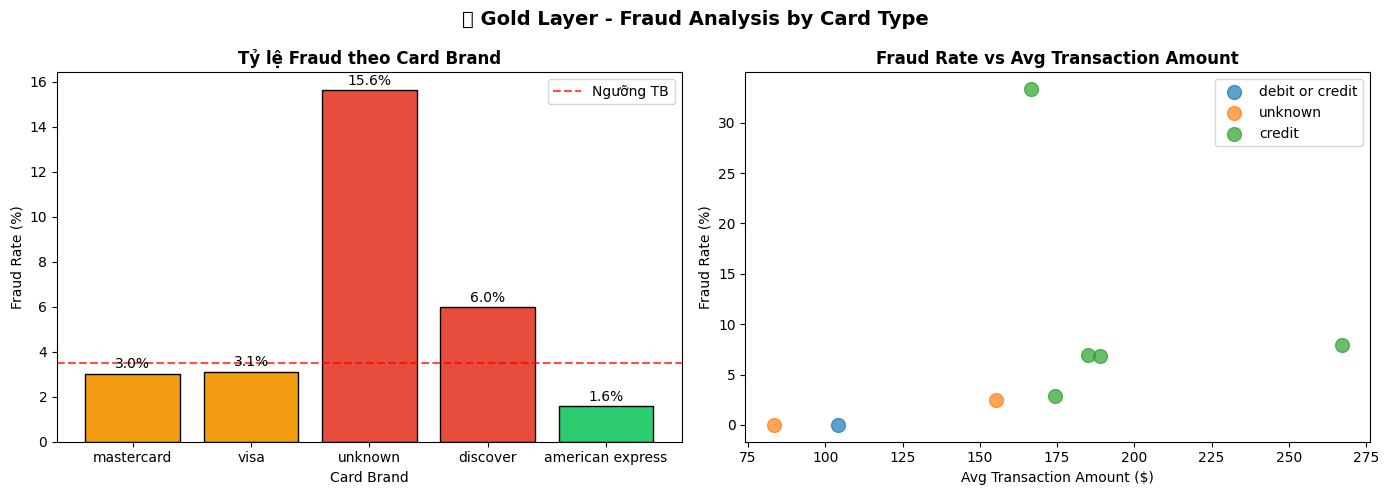

📊 Insight: Card brands với tỷ lệ fraud cao cần được giám sát chặt hơn!


In [11]:
# 📊 VISUALIZATION: Fraud by Card Type
import matplotlib.pyplot as plt
import builtins  # Để sử dụng sum() gốc của Python

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Gold Layer - Fraud Analysis by Card Type', fontsize=14, fontweight='bold')

# Collect data
card_data = df_fraud_by_card.collect()

# 1. Bar chart: Fraud Rate by Card Brand
card_brands = list(set([row['card_brand'] for row in card_data]))[:6]
fraud_rates = []
for brand in card_brands:
    rates = [row['fraud_rate_pct'] for row in card_data if row['card_brand'] == brand]
    fraud_rates.append(builtins.sum(rates)/len(rates) if rates else 0)

colors = ['#e74c3c' if r > 5 else '#f39c12' if r > 3 else '#2ecc71' for r in fraud_rates]
bars = axes[0].bar(card_brands, fraud_rates, color=colors, edgecolor='black')
axes[0].set_title('Tỷ lệ Fraud theo Card Brand', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Card Brand')
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].axhline(y=3.5, color='red', linestyle='--', alpha=0.7, label='Ngưỡng TB')
axes[0].legend()

for bar, rate in zip(bars, fraud_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

# 2. Scatter: Transaction Amount vs Fraud Rate
categories = list(set([row['card_category'] for row in card_data]))
for cat in categories[:3]:
    cat_data = [row for row in card_data if row['card_category'] == cat]
    amounts = [row['avg_transaction_amt'] for row in cat_data]
    rates = [row['fraud_rate_pct'] for row in cat_data]
    axes[1].scatter(amounts, rates, label=cat, s=100, alpha=0.7)

axes[1].set_title('Fraud Rate vs Avg Transaction Amount', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Avg Transaction Amount ($)')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("📊 Insight: Card brands với tỷ lệ fraud cao cần được giám sát chặt hơn!")

## 3. Tạo bảng Gold: Hourly Fraud Analysis
KPI: Phân tích xu hướng gian lận theo giờ trong ngày

In [12]:
# Phân tích gian lận theo giờ trong ngày
df_hourly_fraud = spark.sql("""
    SELECT 
        transaction_hour as hour_of_day,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_amount,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE 0 END), 2) as fraud_amount
    FROM demo.silver.transactions
    GROUP BY transaction_hour
    ORDER BY transaction_hour
""")

df_hourly_fraud.writeTo("demo.gold.hourly_fraud_analysis") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.hourly_fraud_analysis")
df_hourly_fraud.show(24, truncate=False)

✅ Đã tạo bảng demo.gold.hourly_fraud_analysis
+-----------+------------------+-----------+--------------+------------+----------+------------+
|hour_of_day|total_transactions|fraud_count|fraud_rate_pct|total_amount|avg_amount|fraud_amount|
+-----------+------------------+-----------+--------------+------------+----------+------------+
|0          |37795             |1186       |3.14          |4660496.26  |123.31    |167359.24   |
|1          |32797             |1027       |3.13          |3805384.97  |116.03    |139679.91   |
|2          |26732             |1002       |3.75          |2976132.28  |111.33    |122812.96   |
|3          |20802             |797        |3.83          |2217529.21  |106.6     |93367.78    |
|4          |14839             |770        |5.19          |1527838.58  |102.96    |83123.13    |
|5          |9701              |682        |7.03          |1021159.89  |105.26    |79136.28    |
|6          |6007              |467        |7.77          |635052.61   |105.72   

/tmp/ipykernel_1805/252935659.py:44: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


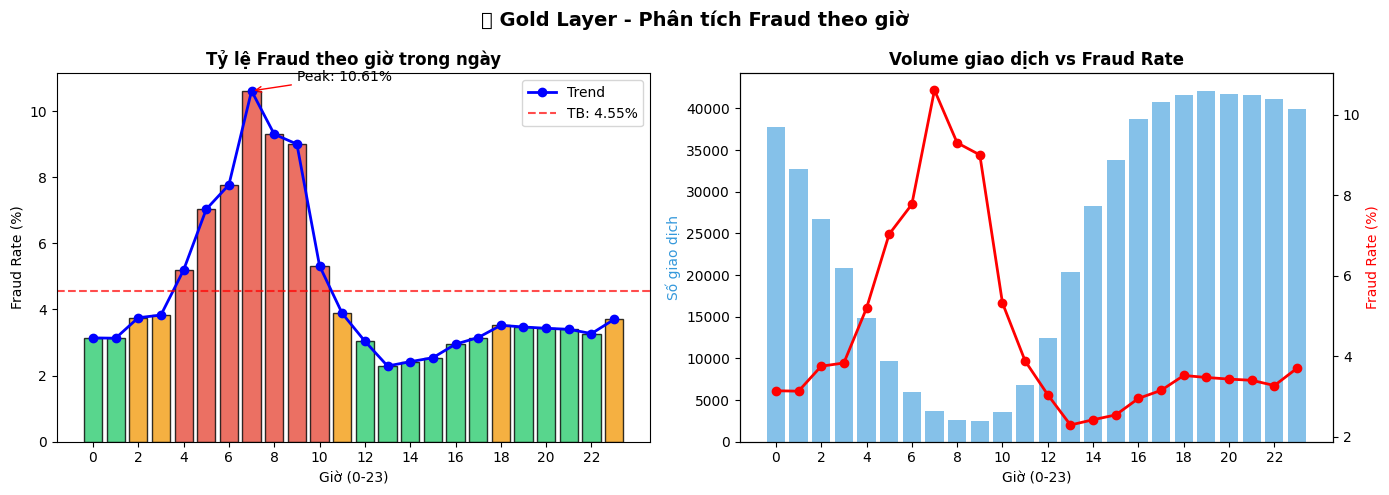

📊 Insight: Giờ có fraud rate cao nhất là 7h (10.61%)
   → Cần tăng cường giám sát vào khung giờ này!


In [16]:
# 📊 VISUALIZATION: Hourly Fraud Analysis
import builtins  # Để sử dụng sum() và max() gốc của Python

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Gold Layer - Phân tích Fraud theo giờ', fontsize=14, fontweight='bold')

# Collect data
hourly_data = df_hourly_fraud.collect()
hours = [row['hour_of_day'] for row in hourly_data]
fraud_rates = [float(row['fraud_rate_pct']) for row in hourly_data]
total_txns = [row['total_transactions'] for row in hourly_data]

# 1. Line chart: Fraud Rate by Hour
colors = ['#e74c3c' if r > 4 else '#f39c12' if r > 3.5 else '#2ecc71' for r in fraud_rates]
axes[0].bar(hours, fraud_rates, color=colors, edgecolor='black', alpha=0.8)
axes[0].plot(hours, fraud_rates, 'b-o', linewidth=2, markersize=6, label='Trend')
axes[0].set_title('Tỷ lệ Fraud theo giờ trong ngày', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Giờ (0-23)')
axes[0].set_ylabel('Fraud Rate (%)')
axes[0].set_xticks(range(0, 24, 2))
avg_rate = builtins.sum(fraud_rates)/len(fraud_rates)
axes[0].axhline(y=avg_rate, color='red', linestyle='--', alpha=0.7, label=f'TB: {avg_rate:.2f}%')
axes[0].legend()

# Highlight peak hours
max_fraud_rate = builtins.max(fraud_rates)
max_fraud_hour = hours[fraud_rates.index(max_fraud_rate)]
axes[0].annotate(f'Peak: {max_fraud_rate:.2f}%', 
                 xy=(max_fraud_hour, max_fraud_rate), 
                 xytext=(max_fraud_hour+2, max_fraud_rate+0.3),
                 fontsize=10, arrowprops=dict(arrowstyle='->', color='red'))

# 2. Dual axis: Transactions vs Fraud Rate
ax2 = axes[1].twinx()
bars = axes[1].bar(hours, total_txns, color='#3498db', alpha=0.6, label='Transactions')
line = ax2.plot(hours, fraud_rates, 'r-o', linewidth=2, label='Fraud Rate')

axes[1].set_title('Volume giao dịch vs Fraud Rate', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Giờ (0-23)')
axes[1].set_ylabel('Số giao dịch', color='#3498db')
ax2.set_ylabel('Fraud Rate (%)', color='red')
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print(f"📊 Insight: Giờ có fraud rate cao nhất là {max_fraud_hour}h ({max_fraud_rate:.2f}%)")
print(f"   → Cần tăng cường giám sát vào khung giờ này!")

## 4. Tạo bảng Gold: Daily Transaction Summary
KPI: Thống kê giao dịch theo ngày (với Partitioning)

In [17]:
# Thống kê theo ngày (transaction_day là số ngày từ mốc thời gian)
df_daily_summary = spark.sql("""
    SELECT 
        transaction_day,
        ProductCD,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_amount,
        MIN(TransactionAmt) as min_amount,
        MAX(TransactionAmt) as max_amount,
        COUNT(DISTINCT card1) as unique_cards
    FROM demo.silver.transactions
    GROUP BY transaction_day, ProductCD
    ORDER BY transaction_day, ProductCD
""")

# Tạo bảng với PARTITIONING theo ProductCD để tối ưu query
df_daily_summary.writeTo("demo.gold.daily_transaction_summary") \
    .tableProperty("format-version", "2") \
    .partitionedBy(col("ProductCD")) \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.daily_transaction_summary với PARTITIONING theo ProductCD")
print(f"📊 Số rows: {df_daily_summary.count():,}")
df_daily_summary.show(10, truncate=False)

✅ Đã tạo bảng demo.gold.daily_transaction_summary với PARTITIONING theo ProductCD
📊 Số rows: 910
+---------------+---------+------------------+-----------+--------------+------------+----------+----------+----------+------------+
|transaction_day|ProductCD|total_transactions|fraud_count|fraud_rate_pct|total_amount|avg_amount|min_amount|max_amount|unique_cards|
+---------------+---------+------------------+-----------+--------------+------------+----------+----------+----------+------------+
|1              |C        |403               |29         |7.20          |17022.98    |42.24     |1.896     |214.128   |93          |
|1              |H        |366               |3          |0.82          |25871.0     |70.69     |15.0      |450.0     |202         |
|1              |R        |171               |12         |7.02          |27750.0     |162.28    |25.0      |1000.0    |114         |
|1              |S        |113               |9          |7.96          |5146.0      |45.54     |5.0     

## 5. Tạo bảng Gold: Fraud by Product Category
KPI: Tỷ lệ gian lận theo loại sản phẩm (ProductCD)

In [18]:
# Phân tích gian lận theo ProductCD
df_product_fraud = spark.sql("""
    SELECT 
        ProductCD as product_category,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE 0 END), 2) as fraud_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_amount,
        ROUND(AVG(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE NULL END), 2) as avg_fraud_amount,
        COUNT(DISTINCT card1) as unique_cards,
        COUNT(DISTINCT CASE WHEN isFraud = 1 THEN card1 ELSE NULL END) as fraud_cards
    FROM demo.silver.transactions
    GROUP BY ProductCD
    ORDER BY fraud_rate_pct DESC
""")

df_product_fraud.writeTo("demo.gold.fraud_by_product") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.fraud_by_product")
df_product_fraud.show(truncate=False)

✅ Đã tạo bảng demo.gold.fraud_by_product
+----------------+------------------+-----------+--------------+-------------+------------+----------+----------------+------------+-----------+
|product_category|total_transactions|fraud_count|fraud_rate_pct|total_amount |fraud_amount|avg_amount|avg_fraud_amount|unique_cards|fraud_cards|
+----------------+------------------+-----------+--------------+-------------+------------+----------+----------------+------------+-----------+
|C               |68519             |8008       |11.69         |2937570.76   |391421.4    |42.87     |48.88           |2413        |385        |
|S               |11628             |686        |5.90          |700813.6     |43416.0     |60.27     |63.29           |1354        |112        |
|H               |33024             |1574       |4.77          |2416368.0    |246632.0    |73.17     |156.69          |4208        |543        |
|R               |37699             |1426       |3.78          |6344975.0    |348050.0   

/tmp/ipykernel_1805/3595619917.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


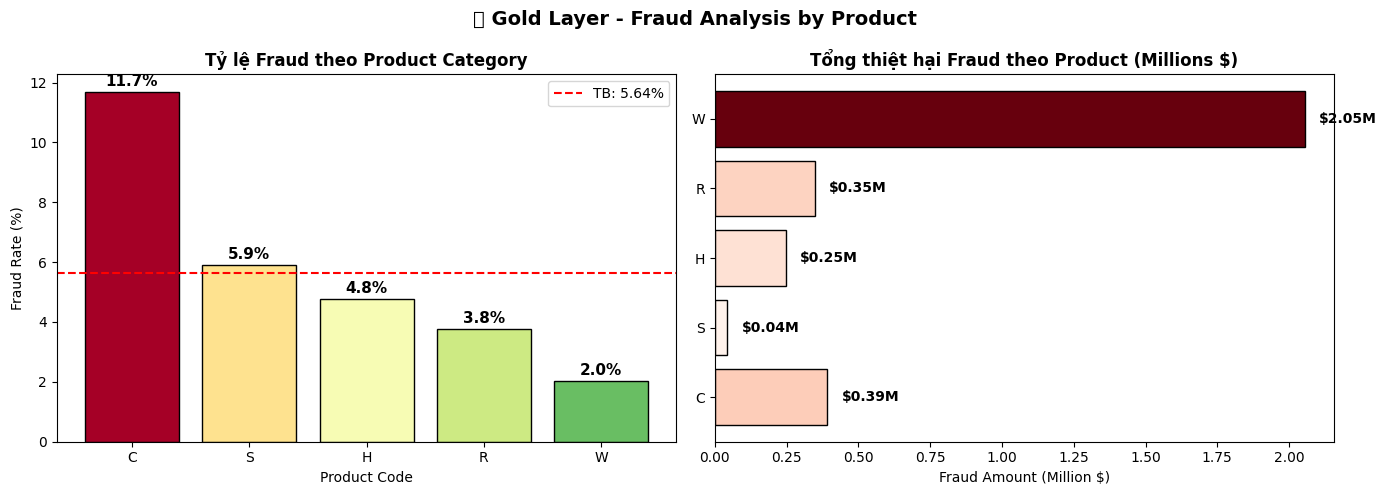

📊 Insights:
   - Product có fraud rate cao nhất: C (11.69%)
   - Product có thiệt hại lớn nhất: W ($2.05M)


In [20]:
# 📊 VISUALIZATION: Fraud by Product Category
import builtins  # Để sử dụng sum() và max() gốc của Python

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Gold Layer - Fraud Analysis by Product', fontsize=14, fontweight='bold')

# Collect data
product_data = df_product_fraud.collect()
products = [row['product_category'] for row in product_data]
fraud_rates = [float(row['fraud_rate_pct']) for row in product_data]
total_txns = [row['total_transactions'] for row in product_data]
fraud_amounts = [float(row['fraud_amount']) for row in product_data]

# 1. Bar chart: Fraud Rate by Product
colors = plt.cm.RdYlGn_r([r/10 for r in fraud_rates])
bars = axes[0].bar(products, fraud_rates, color=colors, edgecolor='black')
axes[0].set_title('Tỷ lệ Fraud theo Product Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Product Code')
axes[0].set_ylabel('Fraud Rate (%)')
avg_rate = builtins.sum(fraud_rates)/len(fraud_rates)
axes[0].axhline(y=avg_rate, color='red', linestyle='--', label=f'TB: {avg_rate:.2f}%')
axes[0].legend()

for bar, rate in zip(bars, fraud_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Treemap-style: Fraud Amount by Product
# Using bar chart as alternative
max_fraud_amt = builtins.max(fraud_amounts)
fraud_amts = [f/1e6 for f in fraud_amounts]  # Convert to millions
max_fraud_amts = builtins.max(fraud_amts)
bars2 = axes[1].barh(products, fraud_amts, color=plt.cm.Reds([a/max_fraud_amts for a in fraud_amts]), 
                      edgecolor='black')
axes[1].set_title('Tổng thiệt hại Fraud theo Product (Millions $)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Fraud Amount (Million $)')

for bar, amt in zip(bars2, fraud_amts):
    axes[1].text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                 f'${amt:.2f}M', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
max_fraud_rate = builtins.max(fraud_rates)
max_fraud_product = products[fraud_rates.index(max_fraud_rate)]
max_amount_product = products[fraud_amounts.index(max_fraud_amt)]
print(f"📊 Insights:")
print(f"   - Product có fraud rate cao nhất: {max_fraud_product} ({max_fraud_rate:.2f}%)")
print(f"   - Product có thiệt hại lớn nhất: {max_amount_product} (${max_fraud_amt/1e6:.2f}M)")

## 6. Tạo bảng Gold: Email Domain Fraud Analysis
KPI: Phân tích gian lận theo email domain

In [21]:
# Phân tích gian lận theo email domain (có thể phát hiện email domains rủi ro cao)
df_email_fraud = spark.sql("""
    SELECT 
        COALESCE(P_emaildomain, 'unknown') as email_domain,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_amount
    FROM demo.silver.transactions
    GROUP BY P_emaildomain
    HAVING COUNT(*) >= 100
    ORDER BY fraud_rate_pct DESC
""")

df_email_fraud.writeTo("demo.gold.fraud_by_email_domain") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.fraud_by_email_domain")
print("📊 Top 10 Email Domains có tỷ lệ gian lận cao nhất:")
df_email_fraud.show(10, truncate=False)

✅ Đã tạo bảng demo.gold.fraud_by_email_domain
📊 Top 10 Email Domains có tỷ lệ gian lận cao nhất:
+--------------+------------------+-----------+--------------+-------------+----------+
|email_domain  |total_transactions|fraud_count|fraud_rate_pct|total_amount |avg_amount|
+--------------+------------------+-----------+--------------+-------------+----------+
|mail.com      |559               |106        |18.96         |88104.05     |157.61    |
|outlook.es    |438               |57         |13.01         |17996.7      |41.09     |
|aim.com       |315               |40         |12.70         |40553.28     |128.74    |
|outlook.com   |5096              |482        |9.46          |575540.62    |112.94    |
|hotmail.es    |305               |20         |6.56          |13133.74     |43.06     |
|live.com.mx   |749               |41         |5.47          |33605.68     |44.87     |
|hotmail.com   |45250             |2396       |5.30          |4521879.96   |99.93     |
|gmail.com     |228355 

## 7. Tạo bảng Gold: Device Type Fraud Analysis
KPI: Phân tích gian lận theo loại thiết bị

In [22]:
# Phân tích gian lận theo loại thiết bị (từ bảng transactions_full đã join với identity)
df_device_fraud = spark.sql("""
    SELECT 
        COALESCE(DeviceType, 'unknown') as device_type,
        COALESCE(browser, 'unknown') as browser,
        COUNT(*) as total_transactions,
        SUM(isFraud) as fraud_count,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 2) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_amount
    FROM demo.silver.transactions_full
    GROUP BY DeviceType, browser
    HAVING COUNT(*) >= 50
    ORDER BY fraud_rate_pct DESC
""")

df_device_fraud.writeTo("demo.gold.fraud_by_device") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.fraud_by_device")
df_device_fraud.show(15, truncate=False)

✅ Đã tạo bảng demo.gold.fraud_by_device
+-----------+-----------------------+------------------+-----------+--------------+------------+----------+
|device_type|browser                |total_transactions|fraud_count|fraud_rate_pct|total_amount|avg_amount|
+-----------+-----------------------+------------------+-----------+--------------+------------+----------+
|desktop    |opera                  |63                |36         |57.14         |5398.33     |85.69     |
|mobile     |chrome 49.0 for android|53                |29         |54.72         |1407.82     |26.56     |
|desktop    |opera generic          |78                |35         |44.87         |5063.13     |64.91     |
|mobile     |chrome 52.0 for android|152               |58         |38.16         |4511.01     |29.68     |
|mobile     |firefox                |117               |43         |36.75         |6018.64     |51.44     |
|desktop    |opera 49.0             |138               |43         |31.16         |9504.87     |

## 8. Tạo bảng Gold: High Risk Transactions (với Z-Ordering)
Bảng các giao dịch có rủi ro cao để phục vụ điều tra

In [23]:
# Tạo bảng các giao dịch rủi ro cao để phục vụ điều tra
df_high_risk = spark.sql("""
    SELECT 
        TransactionID,
        isFraud,
        TransactionAmt,
        ProductCD,
        card_type,
        card_category,
        P_emaildomain,
        transaction_hour,
        transaction_day,
        risk_score,
        payment_method,
        is_high_amount,
        _ingestion_time,
        _transformation_time
    FROM demo.silver.transactions
    WHERE risk_score >= 0.5 OR isFraud = 1 OR is_high_amount = 1
    ORDER BY risk_score DESC
""")

# Ghi với Z-Ordering để tối ưu query theo risk_score và TransactionAmt
df_high_risk.writeTo("demo.gold.high_risk_transactions") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

# Apply Z-Ordering sau khi tạo bảng
spark.sql("""
    CALL demo.system.rewrite_data_files(
        table => 'demo.gold.high_risk_transactions',
        strategy => 'sort',
        sort_order => 'risk_score DESC, TransactionAmt DESC'
    )
""")

print(f"✅ Đã tạo bảng demo.gold.high_risk_transactions với Z-Ordering")
print(f"📊 Số giao dịch rủi ro cao: {df_high_risk.count():,}")

✅ Đã tạo bảng demo.gold.high_risk_transactions với Z-Ordering
📊 Số giao dịch rủi ro cao: 42,534


## 9. Tạo bảng Gold: Overall KPI Summary
Bảng tổng hợp các KPIs chính cho dashboard

In [24]:
# Tạo bảng tổng hợp KPIs
df_kpi_summary = spark.sql("""
    SELECT 
        'overall' as category,
        COUNT(*) as total_transactions,
        SUM(isFraud) as total_fraud,
        ROUND(SUM(isFraud) * 100.0 / COUNT(*), 4) as fraud_rate_pct,
        ROUND(SUM(TransactionAmt), 2) as total_amount,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE 0 END), 2) as fraud_amount,
        ROUND(AVG(TransactionAmt), 2) as avg_transaction_amt,
        ROUND(AVG(CASE WHEN isFraud = 1 THEN TransactionAmt ELSE NULL END), 2) as avg_fraud_amt,
        COUNT(DISTINCT card1) as unique_cards,
        COUNT(DISTINCT CASE WHEN isFraud = 1 THEN card1 ELSE NULL END) as fraud_cards,
        ROUND(AVG(risk_score), 4) as avg_risk_score,
        MAX(TransactionAmt) as max_transaction,
        current_timestamp() as report_generated_at
    FROM demo.silver.transactions
""")

df_kpi_summary.writeTo("demo.gold.kpi_summary") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.gold.kpi_summary")
print("\n📊 OVERALL KPI SUMMARY:")
df_kpi_summary.show(truncate=False)

✅ Đã tạo bảng demo.gold.kpi_summary

📊 OVERALL KPI SUMMARY:
+--------+------------------+-----------+--------------+-------------+------------+-------------------+-------------+------------+-----------+--------------+---------------+--------------------------+
|category|total_transactions|total_fraud|fraud_rate_pct|total_amount |fraud_amount|avg_transaction_amt|avg_fraud_amt|unique_cards|fraud_cards|avg_risk_score|max_transaction|report_generated_at       |
+--------+------------------+-----------+--------------+-------------+------------+-------------------+-------------+------------+-----------+--------------+---------------+--------------------------+
|overall |590540            |20663      |3.4990        |7.973894874E7|3083844.86  |135.03             |149.24       |13553       |1740       |0.1966        |31937.391      |2026-02-02 07:29:37.524246|
+--------+------------------+-----------+--------------+-------------+------------+-------------------+-------------+------------+------

/tmp/ipykernel_1805/2775377514.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


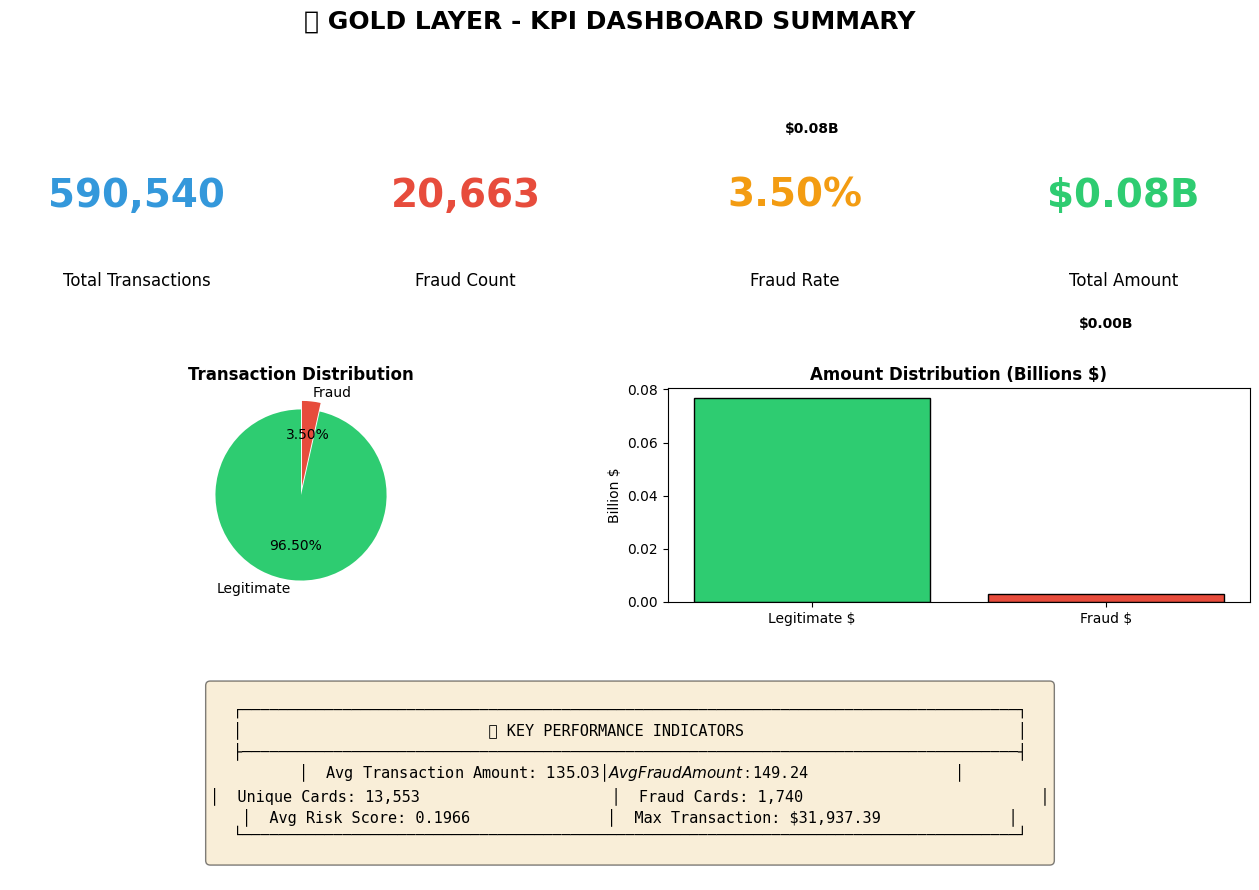

✅ Gold Layer KPI Dashboard hoàn tất!


In [25]:
# 📊 VISUALIZATION: KPI Dashboard Summary
fig = plt.figure(figsize=(16, 10))
fig.suptitle('📊 GOLD LAYER - KPI DASHBOARD SUMMARY', fontsize=18, fontweight='bold')

# Collect KPI data
kpi = df_kpi_summary.collect()[0]

# Create grid
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Total Transactions (Big Number)
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.6, f"{kpi['total_transactions']:,}", fontsize=28, fontweight='bold', 
         ha='center', va='center', color='#3498db')
ax1.text(0.5, 0.2, 'Total Transactions', fontsize=12, ha='center', va='center')
ax1.axis('off')
ax1.set_facecolor('#ecf0f1')

# 2. Fraud Count
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.6, f"{kpi['total_fraud']:,}", fontsize=28, fontweight='bold', 
         ha='center', va='center', color='#e74c3c')
ax2.text(0.5, 0.2, 'Fraud Count', fontsize=12, ha='center', va='center')
ax2.axis('off')

# 3. Fraud Rate
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.6, f"{kpi['fraud_rate_pct']:.2f}%", fontsize=28, fontweight='bold', 
         ha='center', va='center', color='#f39c12')
ax3.text(0.5, 0.2, 'Fraud Rate', fontsize=12, ha='center', va='center')
ax3.axis('off')

# 4. Total Amount
ax4 = fig.add_subplot(gs[0, 3])
ax4.text(0.5, 0.6, f"${kpi['total_amount']/1e9:.2f}B", fontsize=28, fontweight='bold', 
         ha='center', va='center', color='#2ecc71')
ax4.text(0.5, 0.2, 'Total Amount', fontsize=12, ha='center', va='center')
ax4.axis('off')

# 5. Fraud vs Legitimate Pie
ax5 = fig.add_subplot(gs[1, 0:2])
sizes = [kpi['total_transactions'] - kpi['total_fraud'], kpi['total_fraud']]
labels = ['Legitimate', 'Fraud']
colors = ['#2ecc71', '#e74c3c']
ax5.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90, explode=(0, 0.1))
ax5.set_title('Transaction Distribution', fontsize=12, fontweight='bold')

# 6. Amount Distribution
ax6 = fig.add_subplot(gs[1, 2:4])
amounts = [kpi['total_amount'] - kpi['fraud_amount'], kpi['fraud_amount']]
labels = ['Legitimate $', 'Fraud $']
ax6.bar(labels, [a/1e9 for a in amounts], color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax6.set_title('Amount Distribution (Billions $)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Billion $')
for i, (amt, lbl) in enumerate(zip(amounts, labels)):
    ax6.text(i, amt/1e9 + 0.1, f'${amt/1e9:.2f}B', ha='center', fontsize=10, fontweight='bold')

# 7. Key Metrics Table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')
metrics_text = f"""
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                           📊 KEY PERFORMANCE INDICATORS                              │
├─────────────────────────────────────────────────────────────────────────────────────┤
│  Avg Transaction Amount: ${kpi['avg_transaction_amt']:.2f}     │  Avg Fraud Amount: ${kpi['avg_fraud_amt']:.2f}                │
│  Unique Cards: {kpi['unique_cards']:,}                     │  Fraud Cards: {kpi['fraud_cards']:,}                          │
│  Avg Risk Score: {kpi['avg_risk_score']:.4f}               │  Max Transaction: ${kpi['max_transaction']:,.2f}              │
└─────────────────────────────────────────────────────────────────────────────────────┘
"""
ax7.text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center', 
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ Gold Layer KPI Dashboard hoàn tất!")

## 10. Xác minh Gold Layer

In [26]:
# Liệt kê tất cả các bảng trong Gold Layer
print("📁 Danh sách bảng trong Gold Layer:")
spark.sql("SHOW TABLES IN demo.gold").show(truncate=False)

# Thống kê số rows cho mỗi bảng
print("\n📊 Thống kê Gold Tables:")
gold_tables = ['fraud_by_card_type', 'hourly_fraud_analysis', 'daily_transaction_summary', 
               'fraud_by_product', 'fraud_by_email_domain', 'fraud_by_device', 
               'high_risk_transactions', 'kpi_summary']

for table in gold_tables:
    try:
        count = spark.sql(f"SELECT COUNT(*) FROM demo.gold.{table}").collect()[0][0]
        print(f"   - gold.{table}: {count:,} records")
    except Exception as e:
        print(f"   - gold.{table}: Error - {str(e)[:50]}")

📁 Danh sách bảng trong Gold Layer:
+---------+-------------------------+-----------+
|namespace|tableName                |isTemporary|
+---------+-------------------------+-----------+
|gold     |daily_transaction_summary|false      |
|gold     |fraud_by_card_type       |false      |
|gold     |fraud_by_device          |false      |
|gold     |fraud_by_email_domain    |false      |
|gold     |fraud_by_product         |false      |
|gold     |high_risk_transactions   |false      |
|gold     |hourly_fraud_analysis    |false      |
|gold     |kpi_summary              |false      |
+---------+-------------------------+-----------+


📊 Thống kê Gold Tables:
   - gold.fraud_by_card_type: 15 records
   - gold.hourly_fraud_analysis: 24 records
   - gold.daily_transaction_summary: 910 records
   - gold.fraud_by_product: 5 records
   - gold.fraud_by_email_domain: 52 records
   - gold.fraud_by_device: 93 records
   - gold.high_risk_transactions: 42,534 records
   - gold.kpi_summary: 1 records


## ✅ Hoàn thành Gold Layer

**Kết quả:**
- ✅ `fraud_by_card_type` - Tỷ lệ gian lận theo loại thẻ
- ✅ `hourly_fraud_analysis` - Phân tích gian lận theo giờ
- ✅ `daily_transaction_summary` - Thống kê giao dịch theo ngày (PARTITIONED)
- ✅ `fraud_by_product` - Gian lận theo loại sản phẩm
- ✅ `fraud_by_email_domain` - Gian lận theo email domain
- ✅ `fraud_by_device` - Gian lận theo thiết bị
- ✅ `high_risk_transactions` - Giao dịch rủi ro cao (Z-ORDERED)
- ✅ `kpi_summary` - Tổng hợp KPIs

**Tiếp theo:** Chạy notebook `04_serving_layer.ipynb` để tích hợp ClickHouse và tạo Dashboard.